In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', 200)

import ast
import re

# Histogram

Shows distribution of я proteins in modules

In [6]:
modules = pd.read_csv('../data/modules_2.csv', sep=',')

modules.head(3)

,module_id,module_size,cluster_ids,cluster_inds,cluster_sizes
0,1,2,"['sample_1067_contig_10080_protocluster_1_downstream_5', 'sample_8289_contig_377_protocluster_1_downstream_28']","[0, 36907]","[3, 19]"
1,2,3,"['sample_1067_contig_1014_protocluster_1_downstream_4', 'sample_1067_contig_1014_protocluster_1_downstream_5', 'sample_2401_contig_213_protocluster_1_downstream_56']","[1, 2, 20657]","[3, 3, 3]"
2,3,4,"['sample_1067_contig_1016_protocluster_1_upstream_37', 'sample_3057_contig_382_protocluster_1_upstream_7', 'sample_5054_contig_4203_protocluster_1_upstream_2', 'sample_5054_contig_4203_protocluste...","[3, 23536, 30872, 30873]","[3, 88, 3, 3]"


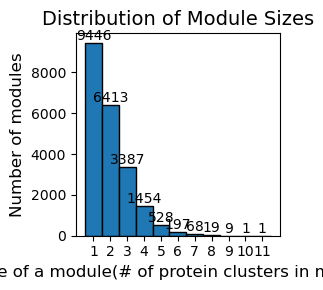

In [7]:
plt.figure(figsize=(3, 3))

bin_edges = np.arange(modules['module_size'].min() - 0.5, modules['module_size'].max() + 1.5, 1)
counts, bins, patches = plt.hist(modules['module_size'], bins=bin_edges, edgecolor='black')

plt.xticks(np.arange(modules['module_size'].min(), modules['module_size'].max() + 1))

for count, patch in zip(counts, patches):
    if count > 0:
        plt.text(patch.get_x() + patch.get_width()/2, 
                patch.get_height() + 0.2, 
                f'{int(count)}', 
                ha='center', 
                va='bottom')

plt.title('Distribution of Module Sizes', fontsize=14)
plt.xlabel('Size of a module(# of protein clusters in module)', fontsize=12)
plt.ylabel('Number of modules', fontsize=12)
#plt.grid(axis='y', alpha=0.5, linestyle='--')

plt.tight_layout()
plt.show()

# Prepare data for heatmap

First, calculate number of proteins in each cluster

In [8]:
filtered_DB = pd.read_csv('../data/filtered_DB_2.csv', sep=',')

filtered_DB.head(3)

,Unnamed: 0,cluster_id,protein_id
0,10,sample_1067_contig_1605_protocluster_1_upstream_10,sample_1067_contig_1605_protocluster_1_upstream_10
1,11,sample_1067_contig_1605_protocluster_1_upstream_10,sample_5650_contig_2119_protocluster_1_upstream_10
2,12,sample_1067_contig_1605_protocluster_1_upstream_10,sample_5650_contig_436_protocluster_1_downstream_31


In [9]:
# Group by 'cluster_id' and aggregate 'protein_id'
clusters = filtered_DB.groupby('cluster_id')['protein_id'].apply(list).reset_index()

clusters['size'] = clusters['protein_id'].apply(len)
clusters.head()

,cluster_id,protein_id,size
0,sample_1067_contig_10080_protocluster_1_downstream_5,"[sample_1067_contig_10080_protocluster_1_downstream_5, sample_5650_contig_114_protocluster_1_downstream_114, sample_14219_contig_1094_protocluster_1_upstream_11]",3
1,sample_1067_contig_1014_protocluster_1_downstream_4,"[sample_1067_contig_1014_protocluster_1_downstream_4, sample_14228_contig_4382_protocluster_1_upstream_2, sample_2401_contig_213_protocluster_1_downstream_58]",3
2,sample_1067_contig_1014_protocluster_1_downstream_5,"[sample_1067_contig_1014_protocluster_1_downstream_5, sample_2401_contig_213_protocluster_1_downstream_57, sample_14228_contig_4382_protocluster_1_upstream_3]",3
3,sample_1067_contig_1016_protocluster_1_upstream_37,"[sample_1067_contig_1016_protocluster_1_upstream_37, sample_5054_contig_119_protocluster_1_downstream_32, sample_5056_contig_637_protocluster_1_upstream_49]",3
4,sample_1067_contig_1021_protocluster_1_upstream_18,"[sample_1067_contig_1021_protocluster_1_upstream_18, sample_1073_contig_267_protocluster_1_downstream_44, sample_9335_contig_1078_protocluster_1_downstream_14, sample_1813_contig_480_protocluster_...",6


In [ ]:
module_protein_ids = {}

for module in modules['module_id'].unique():
    pcs_raw = modules.loc[module - 1, 'cluster_ids']
    
    cluster_proteins = []
    for pcs_name in pcs_raw:
        proteins = clusters[clusters['cluster_id'] == pcs_name]['protein_id'].explode().tolist()
        cluster_proteins.append(proteins)

    module_protein_ids[module] = cluster_proteins

modules['mmseq_protein_ids'] = modules['module_id'].map(module_protein_ids)
modules.head(1)


In [ ]:
modules['number_mmseq_proteins'] = modules['mmseq_protein_ids'].apply(len)

modules['immuneisland_count'] = modules['mmseq_protein_ids'].apply(
    lambda x: sum('immuneisland' in str(protein) for protein in x)
)

modules['immuneisland_fraction'] = modules['immuneisland_count'] / modules['number_mmseq_proteins']

modules.head(1)

def normalize_cluster_name(cluster_name):
    cluster_name = re.sub(r'_protocluster_\d+_upstream', '', cluster_name)
    cluster_name = re.sub(r'_protocluster_\d+_downstream', '', cluster_name)
    return cluster_name


def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return val


modules['cluster_ids'] = modules['cluster_ids'].apply(safe_literal_eval)

modules['normalized_cluster_id'] = modules['cluster_ids'].apply(lambda x: [normalize_cluster_name(cluster) for cluster in x])

modules.head(3)

,module_id,module_size,cluster_ids,cluster_inds,cluster_sizes,normalized_cluster_id,mmseq_protein_ids,number_mmseq_proteins,immuneisland_count,immuneisland_fraction
0,1,2,"[sample_1067_contig_10080_protocluster_1_downstream_5, sample_8289_contig_377_protocluster_1_downstream_28]","[0, 36907]","[3, 19]","[sample_1067_contig_10080_5, sample_8289_contig_377_28]","[[sample_1067_contig_10080_protocluster_1_downstream_5, sample_5650_contig_114_protocluster_1_downstream_114, sample_14219_contig_1094_protocluster_1_upstream_11], [sample_8289_contig_377_protoclu...",2,0,0.0
1,2,3,"[sample_1067_contig_1014_protocluster_1_downstream_4, sample_1067_contig_1014_protocluster_1_downstream_5, sample_2401_contig_213_protocluster_1_downstream_56]","[1, 2, 20657]","[3, 3, 3]","[sample_1067_contig_1014_4, sample_1067_contig_1014_5, sample_2401_contig_213_56]","[[sample_1067_contig_1014_protocluster_1_downstream_4, sample_14228_contig_4382_protocluster_1_upstream_2, sample_2401_contig_213_protocluster_1_downstream_58], [sample_1067_contig_1014_protoclust...",3,0,0.0
2,3,4,"[sample_1067_contig_1016_protocluster_1_upstream_37, sample_3057_contig_382_protocluster_1_upstream_7, sample_5054_contig_4203_protocluster_1_upstream_2, sample_5054_contig_4203_protocluster_1_ups...","[3, 23536, 30872, 30873]","[3, 88, 3, 3]","[sample_1067_contig_1016_37, sample_3057_contig_382_7, sample_5054_contig_4203_2, sample_5054_contig_4203_3]","[[sample_1067_contig_1016_protocluster_1_upstream_37, sample_5054_contig_119_protocluster_1_downstream_32, sample_5056_contig_637_protocluster_1_upstream_49], [sample_3057_contig_382_protocluster_...",4,0,0.0
3,4,2,"[sample_1067_contig_1021_protocluster_1_upstream_18, sample_1067_contig_386_protocluster_1_downstream_25]","[4, 320]","[6, 10]","[sample_1067_contig_1021_18, sample_1067_contig_386_25]","[[sample_1067_contig_1021_protocluster_1_upstream_18, sample_1073_contig_267_protocluster_1_downstream_44, sample_9335_contig_1078_protocluster_1_downstream_14, sample_1813_contig_480_protocluster...",2,0,0.0
4,5,3,"[sample_1067_contig_102_protocluster_1_downstream_13, sample_1067_contig_102_protocluster_1_downstream_7, sample_759_contig_4142_protocluster_1_upstream_5]","[5, 6, 35942]","[16, 4, 4]","[sample_1067_contig_102_13, sample_1067_contig_102_7, sample_759_contig_4142_5]","[[sample_1067_contig_102_protocluster_1_downstream_13, sample_S2455_contig_9693_protocluster_1_upstream_6, sample_2502_contig_75_protocluster_1_downstream_17, sample_3118_contig_4326_protocluster_...",3,0,0.0
...,...,...,...,...,...,...,...,...,...,...
21518,21519,1,[sample_S2455_contig_9953_protocluster_1_immuneisland_5],[42688],[14],[sample_S2455_contig_9953_protocluster_1_immuneisland_5],"[[sample_S2455_contig_9953_protocluster_1_immuneisland_5, sample_14421_contig_4302_protocluster_1_immuneisland_3, sample_14240_contig_44181_protocluster_1_immuneisland_3, sample_3118_contig_54089_...",1,1,1.0
21519,21520,1,[sample_S2455_contig_9_protocluster_2_immuneisland_360],[42698],[7],[sample_S2455_contig_9_protocluster_2_immuneisland_360],"[[sample_S2455_contig_9_protocluster_2_immuneisland_360, sample_5650_contig_24143_protocluster_1_immuneisland_3, sample_2371_contig_15936_protocluster_1_immuneisland_5, sample_14219_contig_32126_p...",1,1,1.0
21520,21521,1,[sample_TMT438_contig_166_protocluster_1_downstream_13],[42701],[4],[sample_TMT438_contig_166_13],"[[sample_TMT438_contig_166_protocluster_1_downstream_13, sample_5650_contig_8_protocluster_3_upstream_180, sample_14198_contig_12537_protocluster_1_upstream_2, sample_2422_contig_4502_protocluster...",1,0,0.0
21521,21522,1,[sample_TMT438_contig_254_protocluster_1_upstream_8],[42704],[3],[sample_TMT438_contig_254_8],"[[sample_TMT438_contig_254_protocluster_1_upstream_8, sample_14210_contig_1817_protocluster_1_downstream_8, sample_17512_contig_164_protocluster_1_upstream_7]]",1,0,0.0


In [ ]:
immune_genes = pd.read_csv("../data/modules_annotation.csv")
immune_genes.head(3)

,Unnamed: 0,module_id,module_size,cluster_id,cluster_size,GO_terms,pfam_term,region,immune
0,0,1,2,sample_1067_contig_10080_5,3,-,-,"downstream: 2, immuneisland: 0, upstream: 1",0
1,1,1,2,sample_2487_contig_1623_7,6,-,Bacterial sugar transferase : 6;,"downstream: 3, immuneisland: 0, upstream: 3",0
2,2,2,5,sample_1067_contig_1014_14,2,-,-,"downstream: 2, immuneisland: 0, upstream: 0",0


In [ ]:
# Map peptide names for each cluster_id from modules dataframe

immune_genes['mmseq_protein_ids'] = None

# Iterate over each row in modules
for _, module_row in modules.iterrows():
    normalized_pcs = module_row['normalized_cluster_id']
    cluster_protein_lists = module_row['mmseq_protein_ids']
    
    # Validate alignment
    if len(normalized_pcs) != len(cluster_protein_lists):
        continue  # or raise an error
    
    for cluster, proteins in zip(normalized_pcs, cluster_protein_lists):
        matches = immune_genes['cluster_id'] == cluster
        match_indices = immune_genes.index[matches]

        for idx in match_indices:
            immune_genes.at[idx, 'mmseq_protein_ids'] = proteins

immune_genes.head()


,Unnamed: 0,module_id,module_size,cluster_id,cluster_size,GO_terms,pfam_term,region,immune,mmseq_protein_ids
0,0,1,2,sample_1067_contig_10080_5,3,-,-,"downstream: 2, immuneisland: 0, upstream: 1",0,"[sample_1067_contig_10080_protocluster_1_downstream_5, sample_5650_contig_114_protocluster_1_downstream_114, sample_14219_contig_1094_protocluster_1_upstream_11]"
1,1,1,2,sample_2487_contig_1623_7,6,-,Bacterial sugar transferase : 6;,"downstream: 3, immuneisland: 0, upstream: 3",0,"[sample_2487_contig_1623_protocluster_1_upstream_7, sample_5650_contig_114_protocluster_1_downstream_115, sample_14219_contig_1094_protocluster_1_upstream_10, sample_1067_contig_10080_protocluster..."
2,2,2,5,sample_1067_contig_1014_14,2,-,-,"downstream: 2, immuneisland: 0, upstream: 0",0,None
3,3,2,5,sample_1067_contig_1014_4,3,-,-,"downstream: 2, immuneisland: 0, upstream: 1",0,"[sample_1067_contig_1014_protocluster_1_downstream_4, sample_14228_contig_4382_protocluster_1_upstream_2, sample_2401_contig_213_protocluster_1_downstream_58]"
4,4,2,5,sample_1067_contig_1014_5,3,-,Transglycosylase SLT domain : 3;,"downstream: 2, immuneisland: 0, upstream: 1",0,"[sample_1067_contig_1014_protocluster_1_downstream_5, sample_2401_contig_213_protocluster_1_downstream_57, sample_14228_contig_4382_protocluster_1_upstream_3]"


# Heatmap

Heatmap shows number of proteins in modules of different sizes and immune protein fraction in a module compared to all proteins in a module

In [36]:
# Group by 'module_id' and aggregate
aggregated_data = immune_genes.groupby('module_id').agg(
    total_cluster_size=('cluster_size', 'sum'),
    total_immune=('immune', 'sum'),
    protein_ids=('mmseq_protein_ids', lambda x: sum([p for p in x if isinstance(p, list)], []))  # flatten nested lists
).reset_index()

# Calculate immune ratio
aggregated_data['immune_to_total_ratio'] = aggregated_data['total_immune'] / aggregated_data['total_cluster_size']

aggregated_data.head(3)


,module_id,total_cluster_size,total_immune,protein_ids,immune_to_total_ratio
0,1,9,0,"[sample_1067_contig_10080_protocluster_1_downstream_5, sample_5650_contig_114_protocluster_1_downstream_114, sample_14219_contig_1094_protocluster_1_upstream_11, sample_2487_contig_1623_protoclust...",0.0
1,2,13,0,"[sample_1067_contig_1014_protocluster_1_downstream_4, sample_14228_contig_4382_protocluster_1_upstream_2, sample_2401_contig_213_protocluster_1_downstream_58, sample_1067_contig_1014_protocluster_...",0.0
2,3,13,0,"[sample_1067_contig_1016_protocluster_1_upstream_37, sample_5054_contig_119_protocluster_1_downstream_32, sample_5056_contig_637_protocluster_1_upstream_49, sample_5054_contig_4203_protocluster_1_...",0.0


In [ ]:
# Group by 'module_id' and aggregate
aggregated_data = immune_genes.groupby('module_id').agg(
    total_cluster_size=('cluster_size', 'sum'),
    total_immune=('immune', 'sum'),
    protein_ids=('mmseq_protein_ids', lambda x: sum([p for p in x if isinstance(p, list)], []))  # flatten nested lists
).reset_index()

# Calculate immune ratio
aggregated_data['immune_to_total_ratio'] = aggregated_data['total_immune'] / aggregated_data['total_cluster_size']

aggregated_data.head(3)


,module_id,total_cluster_size,total_immune,protein_ids,immune_to_total_ratio
0,1,9,0,"[sample_1067_contig_10080_protocluster_1_downstream_5, sample_5650_contig_114_protocluster_1_downstream_114, sample_14219_contig_1094_protocluster_1_upstream_11, sample_2487_contig_1623_protoclust...",0.0
1,2,13,0,"[sample_1067_contig_1014_protocluster_1_downstream_4, sample_14228_contig_4382_protocluster_1_upstream_2, sample_2401_contig_213_protocluster_1_downstream_58, sample_1067_contig_1014_protocluster_...",0.0
2,3,13,0,"[sample_1067_contig_1016_protocluster_1_upstream_37, sample_5054_contig_119_protocluster_1_downstream_32, sample_5056_contig_637_protocluster_1_upstream_49, sample_5054_contig_4203_protocluster_1_...",0.0
3,4,16,0,"[sample_1067_contig_1021_protocluster_1_upstream_18, sample_1073_contig_267_protocluster_1_downstream_44, sample_9335_contig_1078_protocluster_1_downstream_14, sample_1813_contig_480_protocluster_...",0.0
4,5,28,0,"[sample_1067_contig_102_protocluster_1_downstream_13, sample_S2455_contig_9693_protocluster_1_upstream_6, sample_2502_contig_75_protocluster_1_downstream_17, sample_3118_contig_4326_protocluster_1...",0.0
...,...,...,...,...,...
38652,38653,2,0,[],0.0
38653,38654,8,0,"[sample_TMT438_contig_166_protocluster_1_downstream_13, sample_5650_contig_8_protocluster_3_upstream_180, sample_14198_contig_12537_protocluster_1_upstream_2, sample_2422_contig_4502_protocluster_...",0.0
38654,38655,2,0,[],0.0
38655,38656,2,0,[],0.0


/tmp/ipykernel_19355/274281745.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = aggregated_data.pivot_table(


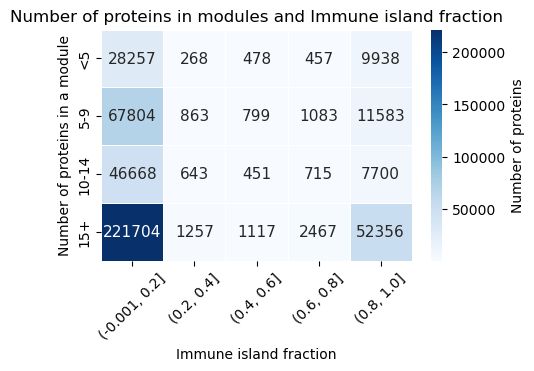

In [ ]:
# Create bins for module size 

aggregated_data['size_bin'] = pd.cut(
    aggregated_data['total_cluster_size'],
    bins=[0, 5, 10, 15, 500000],
    labels=['<5', '5-9', '10-14', '15+'],
    right=False
)

heatmap_data = aggregated_data.pivot_table(
    index='size_bin',
    columns=pd.cut(aggregated_data['immune_to_total_ratio'], bins=5),
    values='total_cluster_size',
    aggfunc='sum',
    fill_value=0
)

plt.figure(figsize=(5, 3))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar_kws={'label': 'Number of proteins'},
    linewidths=0.5,
    annot_kws={"size": 11}
)
plt.title('Number of proteins in modules and Immune island fraction')
plt.xlabel('Immune island fraction')
plt.ylabel('Number of proteins in a module')
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.show()

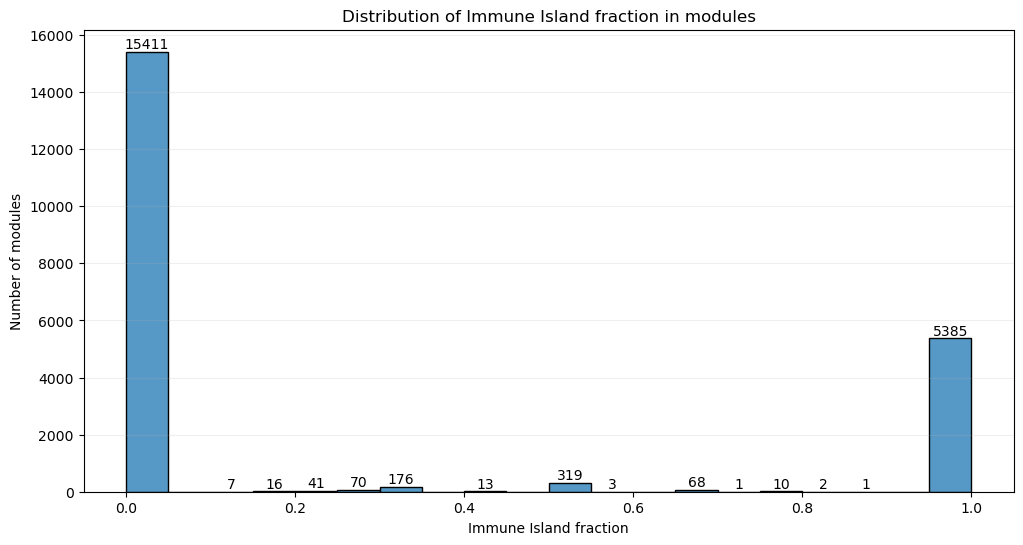

In [ ]:
# Same picture but histogram

plt.figure(figsize=(12, 6))
ax = sns.histplot(
    data=modules,
    x='immuneisland_fraction',
    bins=20,
    edgecolor='black'
)


for patch in ax.patches:
    height = patch.get_height()
    if height > 0:
        ax.text(
            x=patch.get_x() + patch.get_width() / 2,
            y=height + 0.5,
            s=f'{int(height)}',
            ha='center',
            va='bottom',
            fontsize=10
        )

plt.title('Distribution of Immune Island fraction in modules')
plt.xlabel('Immune Island fraction')
plt.ylabel('Number of modules')
plt.grid(axis='y', alpha=0.2)
plt.show()